In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import copy

import mtpy.core.edi as mtedi
from mtpy.core.edi_collection import EdiCollection

import os

import warnings
warnings.filterwarnings('ignore')

In [84]:
def calc_effective_Z(z):
    return np.sqrt(z[:, 0, 0] * z[:, 1, 1] - z[:, 1, 0] * z[:, 0, 1])


def edi_fill_nans(edi):
    """
    Функция заменяет нулевые значения сопротивлений и соответствующие им значения фазы на NaN
    """

    edi.Z.phase_xx[edi.Z.res_xx==0] = np.nan
    edi.Z.res_xx[edi.Z.res_xx==0] = np.nan
    edi.Z.phase_xy[edi.Z.res_xy==0] = np.nan
    edi.Z.res_xy[edi.Z.res_xy==0] = np.nan
    edi.Z.phase_yx[edi.Z.res_yx==0] = np.nan
    edi.Z.res_yx[edi.Z.res_yx==0] = np.nan
    edi.Z.phase_yy[edi.Z.res_yy==0] = np.nan
    edi.Z.res_yy[edi.Z.res_yy==0] = np.nan


def read_edi_files(fnames):
    """
    Функция читает файлы из путей, которые содержатся в списке fnames, и создает список объектов Edi 
    """

    edis = []
    
    for fname in fnames:
        edi = mtedi.Edi()
        edi.read_edi_file(fname)
        edi_fill_nans(edi)
        edis.append(edi)
        
    return edis


def moving_avg_filter(x, data, width):
    """
    Функция для сглаживания скользящим средним 
    """

    data_f = np.empty(len(data))
    
    for i in range(len(data)):
        data_f[i] = np.mean(data[np.logical_and(x >= x[i] - width / 2, x <= x[i] + width / 2)])
        
            
    return data_f
    
    
def calc_log_levels(data, levels):
    ticks = np.arange(np.floor(np.log10(np.nanmin(data))),
                      np.ceil(np.log10(np.nanmax(data))))

    lvls_exp = np.linspace(np.floor(np.log10(np.nanmin(data))),
                           np.ceil(np.log10(np.nanmax(data))), levels)

    return 10 ** lvls_exp, 10 ** ticks
    
    
    
def plot_edi_rho(edis, figsize=(20, 20), plot_type='maps', cmap = cm.jet, levels=50):
    mu0 = 4 * np.pi * 1e-7
    
    """
    Функция для визуализации сопротивлений и фазы для списка Edi 
    Переменная plot_type отвечает за тип визуализации: maps - тепловая карта, любой другой текст - графики
    cmap - цветовая шкала из matplotlib
    """

    fig = plt.figure(figsize=figsize)

    lbls = [['Rho XX', 'PHI XX'], ['Rho XY', 'PHI XY'],
            ['Rho YX', 'PHI YX'], ['Rho YY', 'PHI YY'],
            ['Rho Eff', 'PHI Eff']]
    
    axes = []
    for i in range(5):
        axes.append([])
        for j in range(2):
            axes[i].append(fig.add_subplot(5, 2, i * 2 + 1 + j))
            axes[i][j].grid(True)
            axes[i][j].set_title(lbls[i][j])
            
            if plot_type == 'maps':
                axes[i][j].set_ylabel('t, sec')    
            else:
                axes[i][j].set_xlabel('t, sec')
                axes[i][j].set_ylabel('rho, Ohm*m' if j == 0 else 'phi, deg')


    
    if plot_type == 'maps':        
        unique_freqs = set()
        for edi in edis:
            for f in edi.Z.freq:
                unique_freqs.add(f)
        
        unique_freqs = np.sort(np.array(list(unique_freqs)))[::-1]
        
        times = 1 / unique_freqs
        x = np.arange(len(edis))
        
        res_xx_section = np.zeros([len(times), len(x)]) + np.nan
        res_xy_section = np.zeros([len(times), len(x)]) + np.nan
        res_yx_section = np.zeros([len(times), len(x)]) + np.nan
        res_yy_section = np.zeros([len(times), len(x)]) + np.nan
        phase_xx_section = np.zeros([len(times), len(x)]) + np.nan
        phase_xy_section = np.zeros([len(times), len(x)]) + np.nan
        phase_yx_section = np.zeros([len(times), len(x)]) + np.nan
        phase_yy_section = np.zeros([len(times), len(x)]) + np.nan

        rho_eff_section_real = np.zeros([len(times), len(x)]) + np.nan
        rho_eff_section_imag = np.zeros([len(times), len(x)]) + np.nan

        
        
        for i, edi in enumerate(edis):
            
            res_xx_section[:, i] = np.interp(times, 1 / edi.Z.freq, edi.Z.res_xx)
            res_xy_section[:, i] = np.interp(times, 1 / edi.Z.freq, edi.Z.res_xy)
            res_yx_section[:, i] = np.interp(times, 1 / edi.Z.freq, edi.Z.res_yx)
            res_yy_section[:, i] = np.interp(times, 1 / edi.Z.freq, edi.Z.res_yy)

            phase_xx_section[:, i] = np.interp(times, 1 / edi.Z.freq, edi.Z.phase_xx)
            phase_xy_section[:, i] = np.interp(times, 1 / edi.Z.freq, edi.Z.phase_xy)
            phase_yx_section[:, i] = np.interp(times, 1 / edi.Z.freq, edi.Z.phase_yx)
            phase_yy_section[:, i] = np.interp(times, 1 / edi.Z.freq, edi.Z.phase_yy)

            
            z_eff = np.interp(times, 1 / edi.Z.freq, calc_effective_Z(edi.Z.z))
                        
            r_eff = (z_eff ** 2) * times / 2 / np.pi  * (mu0 * 1e6) # МНОЖИТЕЛЬ КОСТЫЛЬНЫЙ
            rho_eff_section_real[:, i] = np.real(r_eff)
            rho_eff_section_imag[:, i] = np.imag(r_eff)
                                        
                
        
        phase_eff_section = np.arctan2(rho_eff_section_imag, rho_eff_section_real) * 180 / np.pi        
        rho_eff_section = np.sqrt(rho_eff_section_imag ** 2 + rho_eff_section_real ** 2)
        
        phase_eff_section[rho_eff_section == 0] = np.nan
        rho_eff_section[rho_eff_section == 0] = np.nan

                    
        res_list = [res_xx_section, res_xy_section, res_yx_section, res_yy_section, rho_eff_section]
        phase_list = [phase_xx_section, phase_xy_section, phase_yx_section, phase_yy_section, phase_eff_section]
        
        
        for i in range(5):
            lvls, ticks = calc_log_levels(res_list[i], levels)

            c_map = axes[i][0].contourf(x, times, res_list[i], levels=lvls, locator=ticker.LogLocator(), cmap=cmap)
            b_xx = fig.colorbar(c_map, ticks=ticks)
            
            c_map_ph = axes[i][1].contourf(x, times, phase_list[i], cmap=cmap, levels=levels)
            fig.colorbar(c_map_ph)



        
        for ax_lst in axes:
            for ax in ax_lst:
                ax.set_ylim([times[0], times[-1]])
                ax.set_yscale('log')  
                ax.invert_yaxis()

    else:    
        for edi in edis:
            t = 1 / edi.Z.freq

            axes[0][0].loglog(t, edi.Z.res_xx)
            axes[0][1].semilogx(t, edi.Z.phase_xx)
            axes[1][0].loglog(t, edi.Z.res_xy)
            axes[1][1].semilogx(t, edi.Z.phase_xy)
            axes[2][0].loglog(t, edi.Z.res_yx)
            axes[2][1].semilogx(t, edi.Z.phase_yx)
            axes[3][0].loglog(t, edi.Z.res_yy)
            axes[3][1].semilogx(t, edi.Z.phase_yy)
            
            z_eff = calc_effective_Z(edi.Z.z)
            rho_eff = z_eff ** 2 * t / 2 / np.pi / mu0
            phase_eff = np.angle(rho_eff, deg=True)

            axes[4][0].loglog(t, np.abs(rho_eff))
            axes[4][1].semilogx(t, phase_eff)


def interpolate_nans(data):
    if np.any(np.isnan(data)):
        nans = np.isnan(data)
        data[nans]= np.interp(np.arange(len(data))[nans], np.arange(len(data))[~nans], data[~nans])

    return data

            

def normalize_rho(edis, T, n_points):
    """
    Функция для нормализации набора Edi.
    В качестве аргументов принимает:
    T - период в СЕКУНДАХ, на котором происходит нормализация
    n_points - количество точек, по которым происходит осреднение
    """
    
    rhos_xy = np.empty(len(edis))
    rhos_yx = np.empty(len(edis))
    
    for i, edi in enumerate(edis):
        T_id = np.argmin(np.abs(1 / edi.Z.freq - T))
        
        if np.isnan(edi.Z.res_xy[T_id]):
            nans = np.isnan(edi.Z.res_xy)
            rhos_xy[i] = np.interp(T_id, np.arange(len(nans))[~nans], edi.Z.res_xy[~nans])
        else:
            rhos_xy[i] = edi.Z.res_xy[T_id]

        if np.isnan(edi.Z.res_yx[T_id]):
            nans = np.isnan(edi.Z.res_yx)
            rhos_yx[i] = np.interp(T_id, np.arange(len(nans))[~nans], edi.Z.res_yx[~nans])
        else:
            rhos_yx[i] = edi.Z.res_yx[T_id]
                   
    rhos_xy_f = moving_avg_filter(np.arange(len(edis)), rhos_xy, n_points)
    rhos_yx_f = moving_avg_filter(np.arange(len(edis)), rhos_yx, n_points)
    
    
    new_edis = copy.deepcopy(edis)
    
    for i in range(len(edis)):
        res_array = np.empty([len(edis[i].Z.freq), 2, 2])
        phase_array = np.empty([len(edis[i].Z.freq), 2, 2])

        xy_c = rhos_xy_f[i] / rhos_xy[i]
        yx_c = rhos_yx_f[i] / rhos_yx[i]
                
        new_edis[i].Z.res_xy[:] = edis[i].Z.res_xy[:] * xy_c
        new_edis[i].Z.res_yx[:] = edis[i].Z.res_yx[:] * yx_c
        
        new_edis[i].Z.z[:, 0, 1] *= np.sqrt(xy_c)
        new_edis[i].Z.z[:, 1, 0] *= np.sqrt(yx_c)
        
        
        edi_fill_nans(new_edis[i]) 
        
    return new_edis
    



Создаем список файлов

In [85]:
folder = 'data/norm/Prof 1/' 
files_list = os.listdir(folder)
files_list = [folder + fname for fname in files_list if fname.endswith('edi')]

Читаем файлы

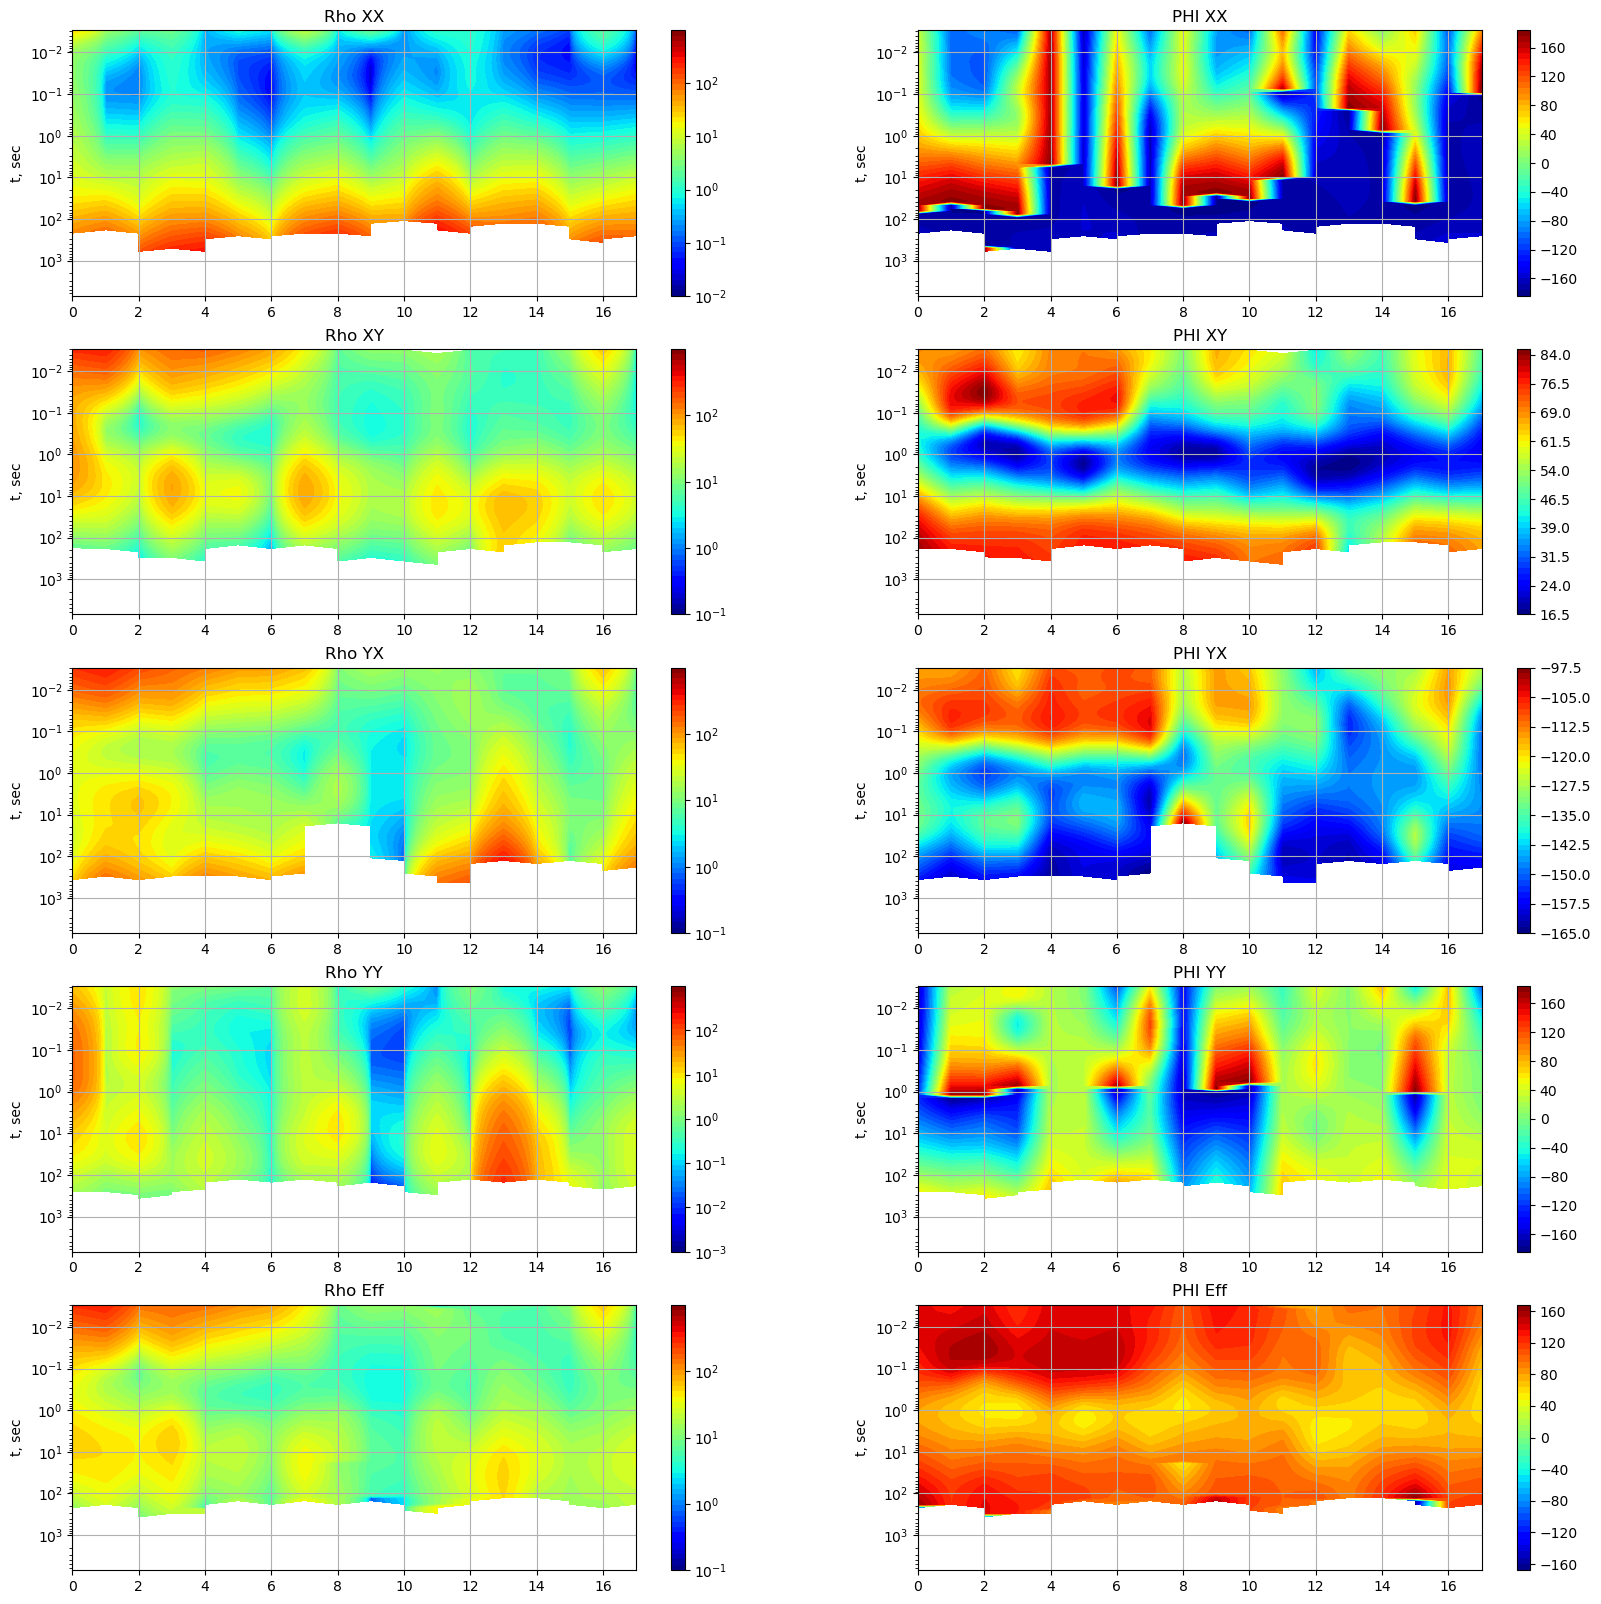

In [86]:
edis = read_edi_files(files_list)
plot_edi_rho(edis)

Нормализация кривых

In [89]:
new_edis = normalize_rho(edis, 1, 10)

33 0.984251968503937
33 0.984251968503937
33 0.984251968503937
33 0.984251968503937
33 0.984251968503937
33 0.984251968503937
33 0.984251968503937
34 0.984251968503937
33 0.984251968503937
34 0.984251968503937
34 0.984251968503937
34 0.984251968503937
34 0.984251968503937
33 0.984251968503937
33 0.984251968503937
33 0.984251968503937
33 0.984251968503937
33 0.984251968503937


Сравнение результатов

(0.5416613323041399, 506.79277355370687)

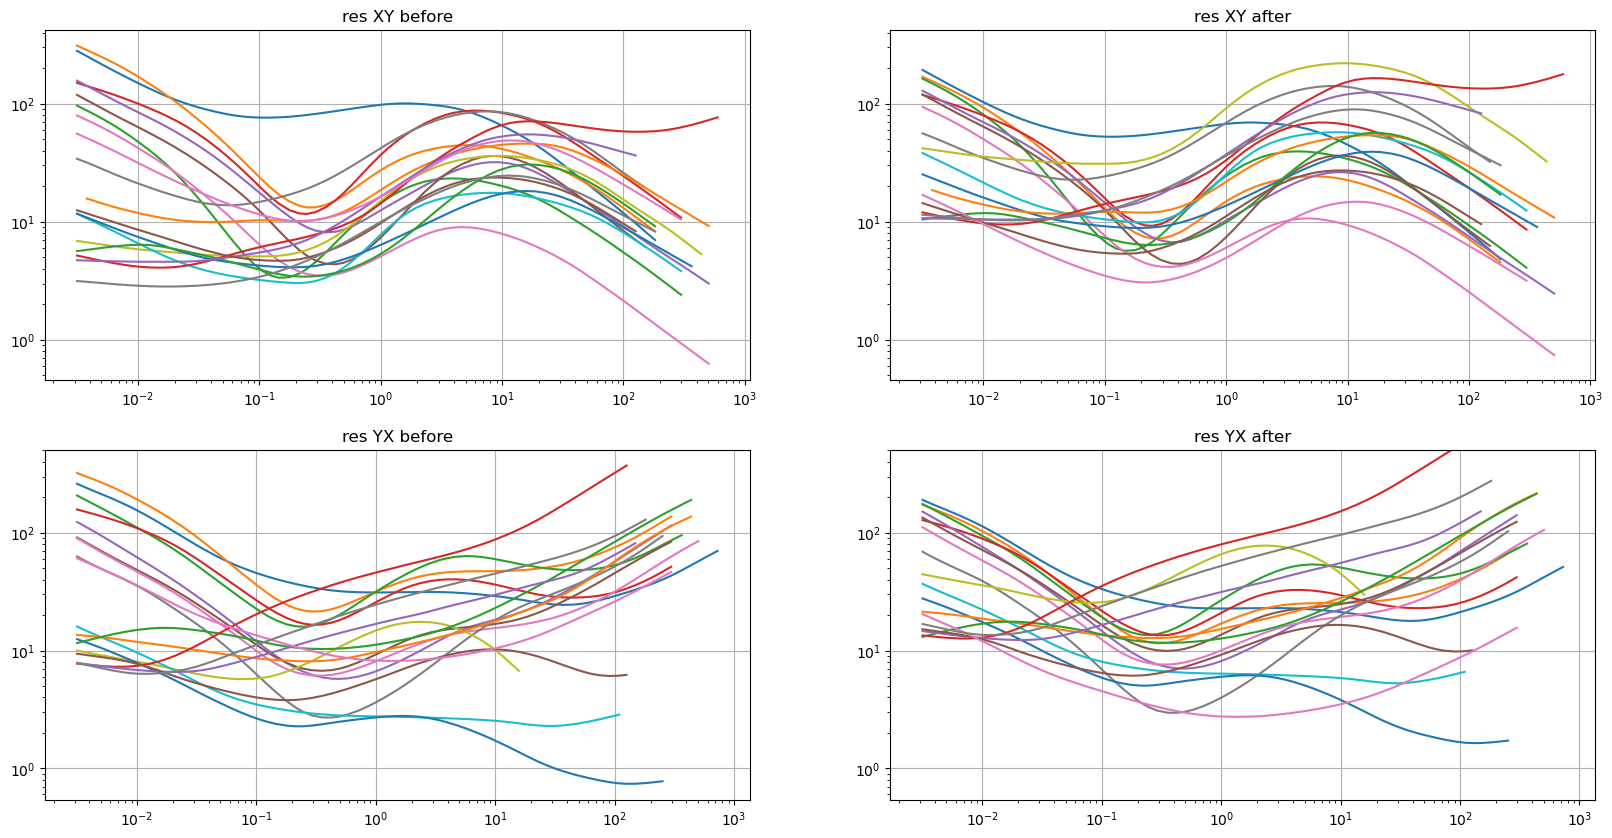

In [69]:
fig = plt.figure(figsize=(20, 10))


ax_xy_1 = fig.add_subplot(2,2,1)
ax_xy_2 = fig.add_subplot(2,2,2)
ax_yx_1 = fig.add_subplot(2,2,3)
ax_yx_2 = fig.add_subplot(2,2,4)


for i in range(len(edis)):
    ax_xy_1.loglog(1 / edis[i].Z.freq, edis[i].Z.res_xy)
    ax_xy_2.loglog(1 / edis[i].Z.freq, new_edis[i].Z.res_xy)
    ax_yx_1.loglog(1 / edis[i].Z.freq, edis[i].Z.res_yx)
    ax_yx_2.loglog(1 / edis[i].Z.freq, new_edis[i].Z.res_yx)
    
    
ax_xy_1.grid(True)
ax_xy_2.grid(True)
ax_yx_1.grid(True)
ax_yx_2.grid(True)

ax_xy_1.set_title('res XY before')
ax_xy_2.set_title('res XY after')
ax_yx_1.set_title('res YX before')
ax_yx_2.set_title('res YX after')


ax_xy_2.set_ylim(ax_xy_1.get_ylim())
ax_yx_2.set_ylim(ax_yx_1.get_ylim())


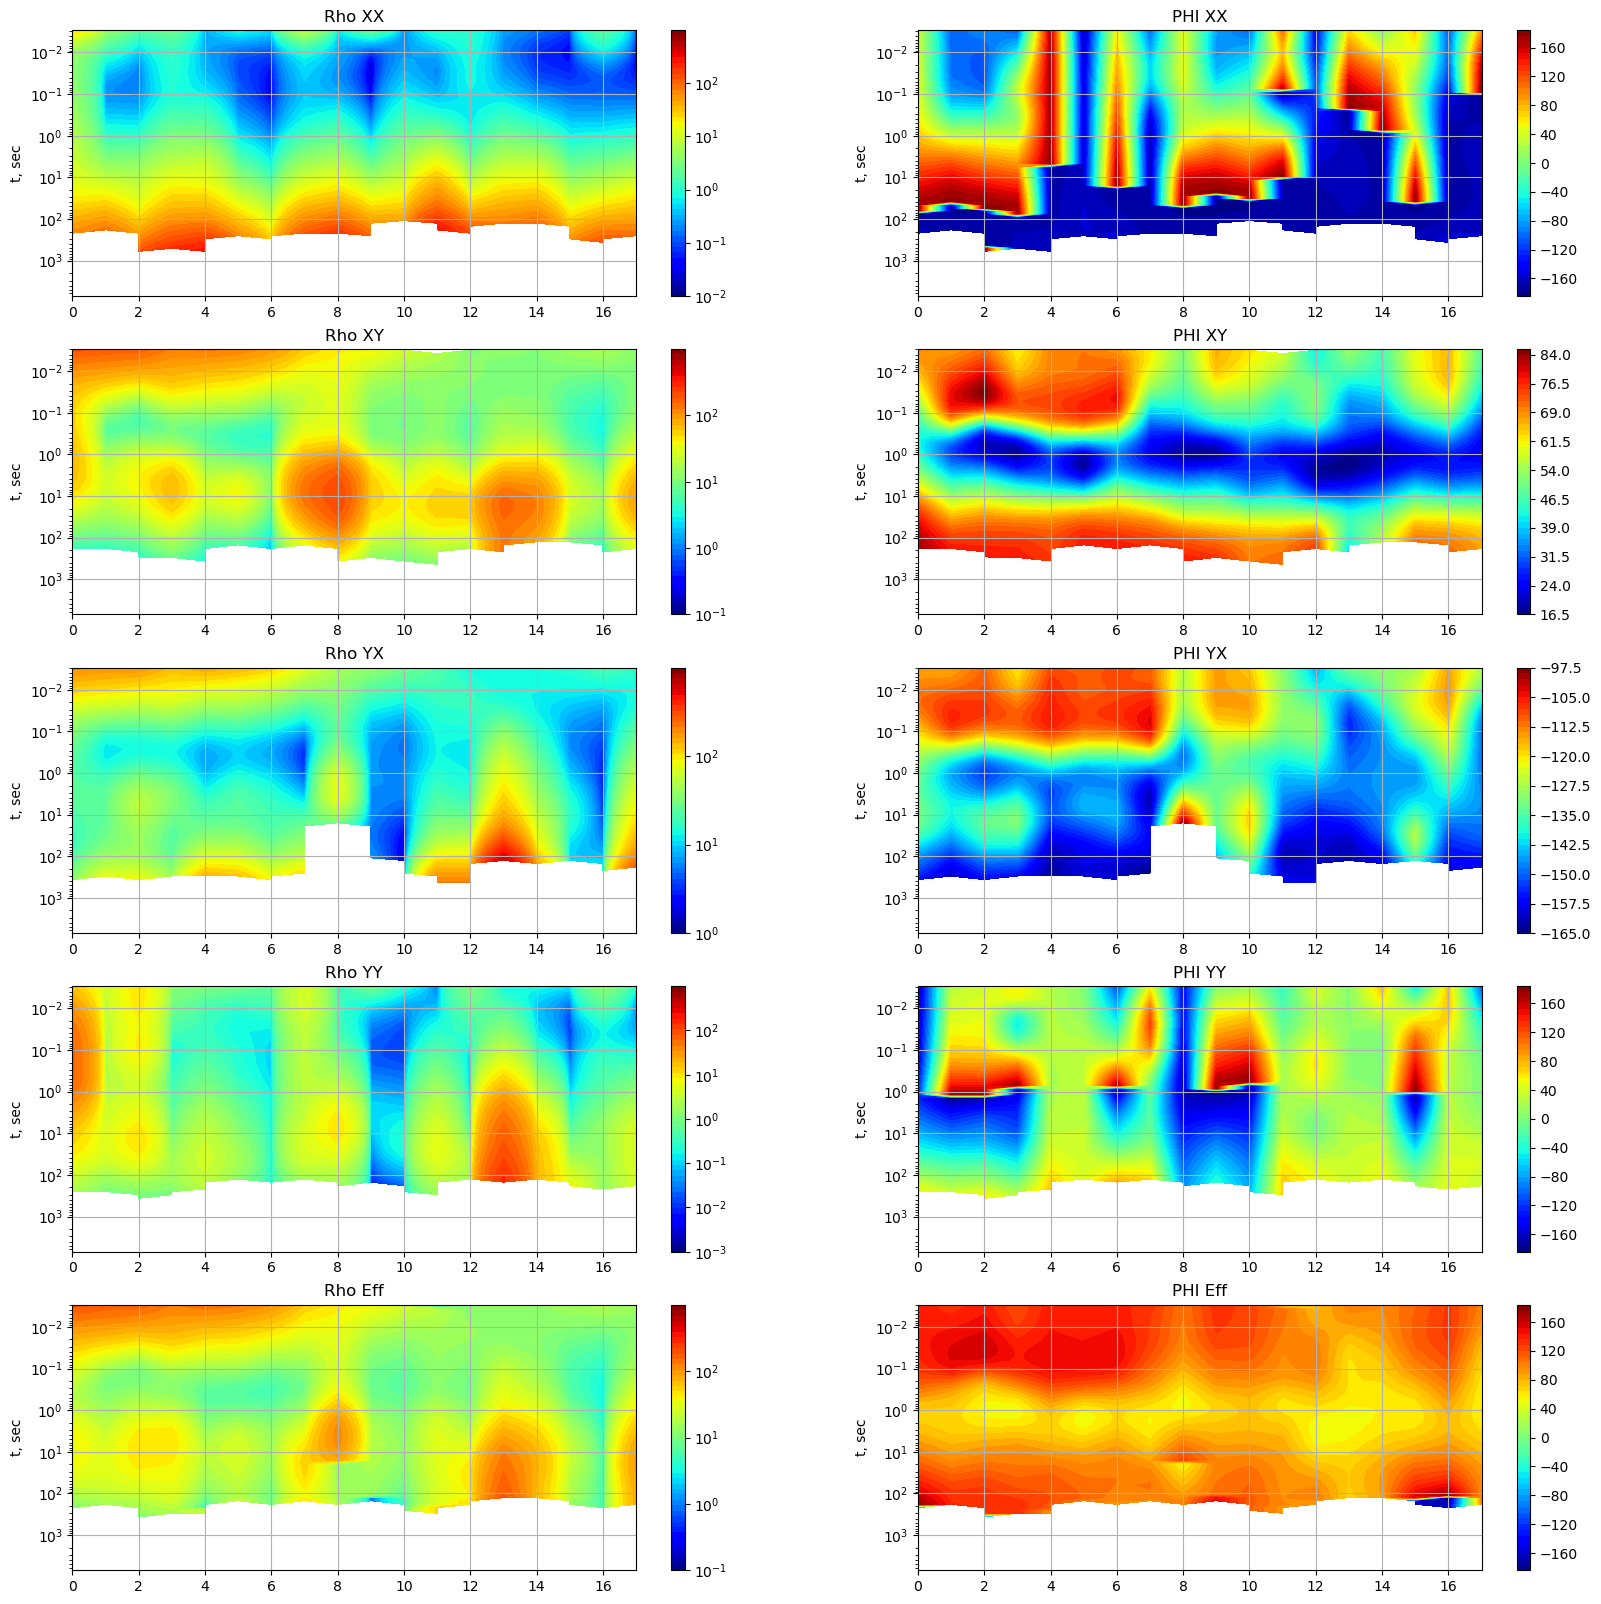

In [70]:
plot_edi_rho(new_edis)

Сохранение результатов

In [102]:
# у класса Edi есть метод для сохраения Edi файла, в качестве аргумента можно передать имя. 
for i, edi in enumerate(new_edis):
    edi.write_edi_file('normalized_{}.edi'.format(i + 1))